<a href="https://colab.research.google.com/github/moonorange/Chat_app_firebase/blob/master/mask_rcnn_predict_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [14]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=53c14d656b13452f7d8781773ddac6d06fc641e10855d106eecc7c50917ffb56
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 5.3.1
    Uninstalling PyYAML-5.3.1:
      Successfully uninstalled PyYAML-5.3.1


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-m84w3lzk
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-m84w3lzk
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267011 sha256=b31a8b3970595a7a9adef5b0545c0309c75d3eb5b86821b508f0bd48c40820dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ywzn3jg/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.0
    Uninstalling pycocotools-2.0.0:
      Successfully uninstalled pycocotools-2.0.0


1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [15]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
# ipdb for debug
!pip install ipdb

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import ipdb

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Register the farmland dataset to detectron2.
Here, the dataset is already in coco format


In [17]:
# TODO change google drive to SAgri's one
# mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
cd drive/My Drive/test_mask-rcnn/

[Errno 2] No such file or directory: 'drive/My Drive/test_mask-rcnn/'
/content/drive/My Drive/test_mask-rcnn


In [19]:
ls

COCO_400_cutoff/  coco_overlap/  labeled_data/  output/


In [0]:
# 明るさ調整イメージ
from detectron2.data.datasets import register_coco_instances
register_coco_instances("farm_400_clean_coco", {}, "labeled_data/COCO/annotations_norm.json", "labeled_data/COCO")

In [21]:
# Metadataと辞書定義
from detectron2.data import DatasetCatalog, MetadataCatalog

farm_train_coco_metadata = MetadataCatalog.get("farm_400_clean_coco")
# create dicts that has annotations of the images
# one dict to represent the annotations of one image.
dataset_dicts = DatasetCatalog.get("farm_400_clean_coco")


[06/12 07:37:43 d2.data.datasets.coco]: Loading labeled_data/COCO/annotations_norm.json takes 2.08 seconds.
[06/12 07:37:43 d2.data.datasets.coco]: Loaded 3001 images in COCO format from labeled_data/COCO/annotations_norm.json


In [0]:
## 400*400
from detectron2.data.datasets import register_coco_instances
register_coco_instances("farm_test_coco_400", {}, "labeled_data/COCO_test/annotations.json", "drive/My Drive/test_mask-rcnn/labeled_data/COCO_test")

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the farmland validation dataset. First, let's create a predictor using the model we just trained:



In [22]:
ls labeled_data/validation/JPEGImages/

0_long135dot0640335486521-lati35dot179235648097404-size400.jpg
1_long135dot0640335486521-lati35dot17748177830473-size400.jpg
2_long135dot0640335486521-lati35dot17572787067057-size400.jpg
3_long135dot0640335486521-lati35dot173973925195725-size400.jpg
4_long135dot0640335486521-lati35dot172219941881046-size400.jpg
5_long135dot0640335486521-lati35dot170465920727366-size400.jpg


In [0]:
OUTPUT_DIR = "output/output_original_data_R50"
VALIDATION_IMAGE_DIR = "labeled_data/validation/JPEGImages/*.jpg"


保存したモデルを使う


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    256
) 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

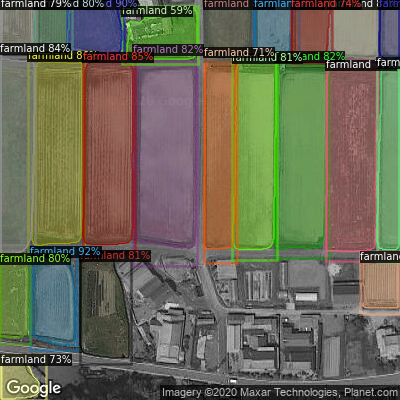

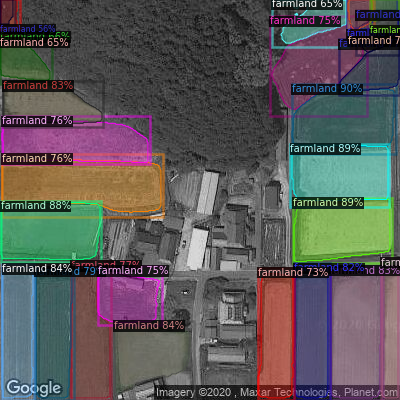

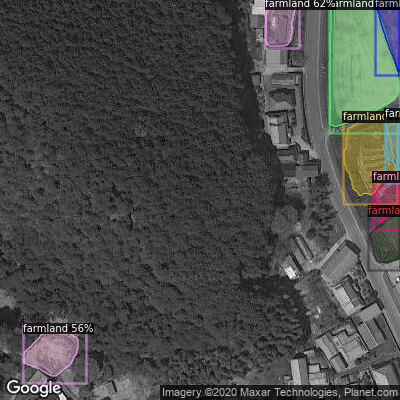

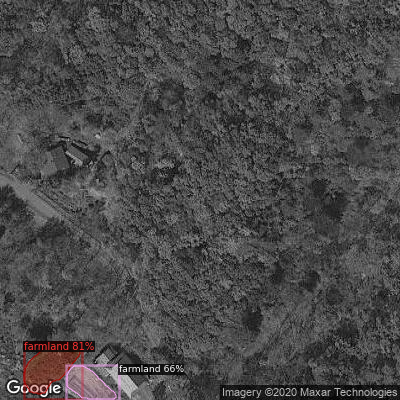

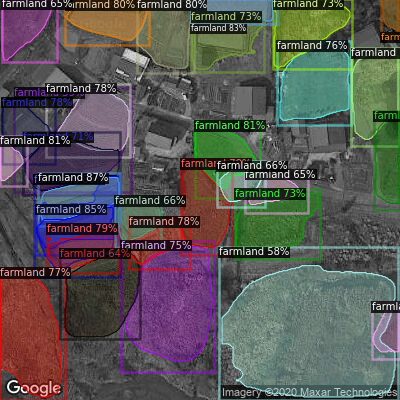

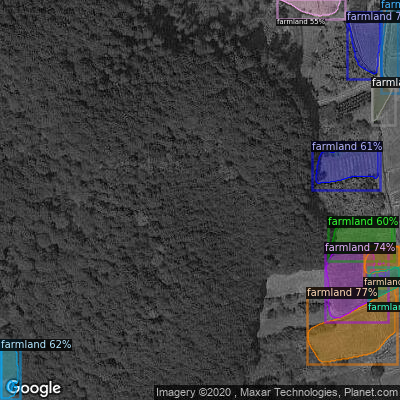

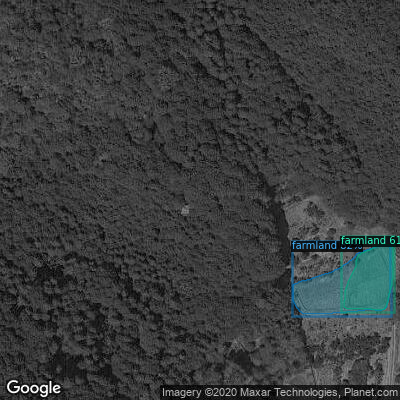

In [40]:
# 検証データ予測確認
from detectron2.utils.visualizer import ColorMode
import glob
for path in glob.glob(VALIDATION_IMAGE_DIR):
  im = cv2.imread(path)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                 metadata=farm_train_coco_metadata,
                 instance_mode=ColorMode.IMAGE_BW)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
PREDICTED_IMAGE_DIR = "output/predicted_images/"

In [0]:
from skimage import measure
import imageio
import pathlib


マスク作成

In [0]:
target_class = MetadataCatalog.get("farm_400_clean_coco").thing_classes.index("farmland")
classes = np.asarray(outputs["instances"].to("cpu").pred_classes)
masks = np.asarray(outputs["instances"].to("cpu").pred_masks)[classes==target_class].astype("uint8")

In [8]:
ls

drive/  sample_data/


In [0]:
# 予測からマスク
import cv2
import os
from detectron2.utils.visualizer import ColorMode
import glob
import matplotlib as plt
for path in glob.glob(VALIDATION_IMAGE_DIR):
  im = cv2.imread(path)
  outputs = predictor(im)
  target_class = MetadataCatalog.get("farm_400_clean_coco").thing_classes.index("farmland")
  classes = np.asarray(outputs["instances"].to("cpu").pred_classes)
  mask = outputs["instances"].pred_masks.sum(0) > 0
  mask = torch.stack([mask, mask, mask], dim=2)
  mask = mask.cpu().numpy().astype("uint8")
  instances = cv2.multiply(im, mask)
  cv2_imshow(instances)

In [0]:
# 予測からバイナリ画像出力
import cv2
import os
from detectron2.utils.visualizer import ColorMode
import glob
import matplotlib as plt
for path in glob.glob(VALIDATION_IMAGE_DIR):
  im = cv2.imread(path)
  outputs = predictor(im)
  target_class = MetadataCatalog.get("farm_400_clean_coco").thing_classes.index("farmland")
  classes = np.asarray(outputs["instances"].to("cpu").pred_classes)
  mask = outputs["instances"].pred_masks.sum(0) > 0
  mask = torch.stack([mask, mask, mask], dim=2)
  mask = mask.cpu().numpy().astype("uint8")
  instances = cv2.multiply(im, mask)
  instances = np.where(instances > 0, 255, instances)
  cv2_imshow(instances)

In [77]:
# 予測からバイナリ画像出力
import cv2
import os
import glob
for path in glob.glob(VALIDATION_IMAGE_DIR):
  im = cv2.imread(path)
  outputs = predictor(im)
  target_class = MetadataCatalog.get("farm_400_clean_coco").thing_classes.index("farmland")
  classes = np.asarray(outputs["instances"].to("cpu").pred_classes)
  masks = np.asarray(outputs["instances"].to("cpu").pred_masks)[classes==target_class].astype("uint8")
  contours = [ cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] for m in masks]

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


# shpファイル作成


In [0]:
PREDICTED_IMAGE_DIR = "output/predicted_images/"
OUTPUT_IMAGE_SIZE = 256
PIXEL_SIZE = 400
IMAGE_SIZE = (PIXEL_SIZE, PIXEL_SIZE)
HALF_PIXEL_SIZE = PIXEL_SIZE / 2
L = 85.05112878
ZOOM = 18


In [0]:
MESSAGE_FORMAT = "========== {} ==========="


class Log:
    @classmethod
    def start(cls, message):
        cls.__log("START", message)

    @classmethod
    def loaded(cls, message):
        cls.__log("LOADED", message)

    @classmethod
    def info(cls, message):
        cls.__log("INFO", message)

    @classmethod
    def __log(cls, status, message):
        start_message = "{}: {}".format(status, message)
        print(MESSAGE_FORMAT.format(start_message))

In [0]:
def load_existed_file_names(image_dir=PREDICTED_IMAGE_DIR, extension='jpg'):
  paths = pathlib.Path(image_dir).glob('*.' + extension)
  file_names = set()
  for path in paths:
      file_names.add(path.name)
  return file_names

In [0]:
from dataclasses import dataclass
import re


@dataclass(frozen=True)
class FileName:
    lng: float
    lat: float
    time: int
    size: int
    path: str

    @property
    def value(self):
        return "{}_long{}-lati{}-size{}".format(self.time, self.lng, self.lat, self.size).replace('.', 'dot')

    @property
    def jpg(self):
        return self.value + ".jpg"

    @property
    def png(self):
        return self.value + ".png"

    @property
    def json(self):
        return self.value + ".json"

    @property
    def json_url(self):
        return self.path + self.json

    @property
    def jpg_path(self):
        return self.path + self.jpg

    @property
    def png_path(self):
        return self.path + self.png

In [0]:
def create_from_filename(filename, size=PIXEL_SIZE, path=PREDICTED_IMAGE_DIR):
    dot_converted_filename = filename.replace('dot', '.')
    time = int(re.search('^([\d\.]*)_long', dot_converted_filename).group(1))
    lng = float(re.search('long([\d\.]*)', dot_converted_filename).group(1))
    lat = float(re.search('lati([\d\.]*)', dot_converted_filename).group(1))
    size = int(re.search('size(\d*)', dot_converted_filename).group(1))
    return FileName(lng=lng, lat=lat, time=time, size=size, path=path)

In [0]:
def get(filename):
    polypic = imageio.imread(filename.jpg_path)
    return polypic

In [0]:
def convert_contours(image):
    contours = measure.find_contours(image, 1)
    reverse_contours = []
    for contour in contours:
        reverse_contour = list(map(lambda item: [item[1], item[0]], contour.tolist()))
        reverse_contours.append(reverse_contour)
    return reverse_contours

In [0]:
from dataclasses import dataclass


@dataclass(frozen=True)
class Point:
    lng: float
    lat: float
    x: int
    y: int

    def x_diff(self, polygon):
        return polygon.x - self.x

    def y_diff(self, polygon):
        return polygon.y - self.y

In [0]:
import math


class LocationConverter:
    @classmethod
    def convert_lng_to_x(cls, long):
        return round((2 ** (ZOOM + 7)) * ((long / 180) + 1))

    @classmethod
    def convert_lat_to_y(cls, lati):
        return round(((2 ** (ZOOM + 7)) / math.pi) * ((-1 * math.atanh(math.sin((math.pi / 180) * lati))) + (math.atanh(math.sin((math.pi / 180) * L)))))

    @classmethod
    def convert_x_to_lng(cls, x):
        return 180 * ((x / 2 ** (ZOOM + 7)) - 1)

    @classmethod
    def convert_y_to_lat(cls, y):
        atanh_value = math.sin((math.pi / 180) * L)
        tanh_value = -1 * (math.pi / (2 ** (ZOOM + 7))) * y + math.atanh(atanh_value)
        return (180 / math.pi) * (math.asin(math.tanh(tanh_value)))

In [0]:
class PointFactory:
    @classmethod
    def create_from_x_y(cls, x, y):
        lng = LocationConverter.convert_x_to_lng(x)
        lat = LocationConverter.convert_y_to_lat(y)
        return Point(x=x, y=y, lng=lng, lat=lat)

    @classmethod
    def create_from_lat_lng(cls, lat, lng):
        x = LocationConverter.convert_lng_to_x(lng)
        y = LocationConverter.convert_lat_to_y(lat)
        return Point(x=x, y=y, lng=lng, lat=lat)

    @classmethod
    def create_from_filename(cls, filename):
        x = LocationConverter.convert_lng_to_x(filename.lng)
        y = LocationConverter.convert_lat_to_y(filename.lat)
        return Point(x=x, y=y, lng=filename.lng, lat=filename.lat)

In [0]:
class CountourConverter:
    @classmethod
    def convert_countours_to_coordinate(cls, countours, origin, size):
        diff = size / 2
        x = origin.x - diff
        y = origin.y - diff

        exteriors = []
        for countour in countours:
            exterior = []
            for element in countour:
              point = PointFactory.create_from_x_y(x=x + (element[0] / OUTPUT_IMAGE_SIZE)
                                                     * size, y=y + (element[1] / OUTPUT_IMAGE_SIZE) * size)
              exterior.append([point.lng, point.lat])
            exteriors.append(exterior)
        return exteriors

In [0]:
def generate_polygon_exterior(filename):
        polypic = get(filename)
        contours = convert_contours(polypic[:, :, 0])  # 畑
        contours.extend(convert_contours(
            polypic[:, :, 1]))  # 田んぼ
        origin = PointFactory.create_from_filename(filename=filename)

        return CountourConverter.convert_countours_to_coordinate(contours, origin, filename.size)

In [0]:
def generate_exterior_from_predicted_image():
    filenames = load_existed_file_names(
        PREDICTED_IMAGE_DIR, 'jpg')

    polygon_exteriors = []

    for _filename in filenames:
      filename = create_from_filename(
          _filename, path=PREDICTED_IMAGE_DIR)
      polygon_exterior = generate_polygon_exterior(filename)
      polygon_exteriors.append(polygon_exterior)

    return polygon_exteriors